In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
file_path = r"C:\6th Semester\Deep Learning\combined_data.csv"
df = pd.read_csv(file_path)

In [4]:
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.007583,56.61,6.11,64.64,2.747407,2.747407,0.0,0.0,0.0,0.0,...,3.991182,54.67,8.303355e+07,9.5,10.601583,5.649454,89.956773,0.19,141.55,DDoS-TCP_Flood
1,0.000000,54.00,6.00,64.00,1.355467,1.355467,0.0,1.0,0.0,1.0,...,0.000000,54.00,8.334938e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
2,0.026013,8096.66,16.89,63.78,35366.177892,35366.177892,0.0,0.0,0.0,0.0,...,0.035299,50.08,8.310301e+07,9.5,10.000840,0.050526,0.063823,0.02,141.55,DDoS-UDP_Flood
3,0.000000,0.00,1.00,64.00,36.461746,36.461746,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.312817e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
4,0.011897,628.91,5.72,60.55,19.894312,19.894312,0.0,0.0,0.0,0.0,...,488.244700,791.22,8.333535e+07,9.5,36.995287,689.931968,278334.787869,0.95,141.55,DDoS-ACK_Fragmentation


In [5]:
# Map labels: 1 for any DDoS attack, 0 for BenignTraffic
df['label'] = df['label'].apply(lambda x: 0 if x == 'BenignTraffic' else 1)

# Verify the new class distribution
print(df['label'].value_counts())

label
1    2042081
0      66228
Name: count, dtype: int64


In [6]:
# Separate the two classes
df_ddos = df[df['label'] == 1]
df_benign = df[df['label'] == 0]

# Undersample DDoS to match benign class count
df_ddos_sampled = df_ddos.sample(n=len(df_benign), random_state=42)

# Combine the two
df_balanced = pd.concat([df_ddos_sampled, df_benign], axis=0)

# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print(df_balanced['label'].value_counts())

label
0    66228
1    66228
Name: count, dtype: int64


In [7]:
X = df_balanced.drop(columns=['label'])
y = df_balanced['label']

In [8]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Reshape for LSTM & GRU input (samples, time steps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [10]:
print("✅ Data preprocessed successfully!")
print("X_train_reshaped shape:", X_train_reshaped.shape)
print("y_train shape:", y_train.shape)
# Initialize strategy for CPU/GPU
strategy = tf.distribute.get_strategy()
print("✅ Using strategy:", strategy)
print(tf.config.list_logical_devices())

✅ Data preprocessed successfully!
X_train_reshaped shape: (105964, 1, 46)
y_train shape: (105964,)
✅ Using strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x00000283B341ADE0>
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]


In [20]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Build the model
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(1, X_train_reshaped.shape[2])),
    GRU(32),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=5,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping],
    batch_size= 258
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

Epoch 1/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9346 - loss: 0.2430 - val_accuracy: 0.9989 - val_loss: 0.0058
Epoch 2/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9992 - loss: 0.0049 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 3/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9997 - loss: 0.0021 - val_accuracy: 0.9997 - val_loss: 0.0013
Epoch 4/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9998 - val_loss: 8.5895e-04
Epoch 5/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9998 - loss: 8.2450e-04 - val_accuracy: 0.9998 - val_loss: 9.4063e-04
828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9999 - loss: 5.8545e-04
✅ Test Accuracy: 0.9998
✅ Test Loss: 0.0009


In [12]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f"✅ Model Test Accuracy: {test_acc:.4f}")
print(f"✅ Model Test Loss: {test_loss:.4f}")
# Get predictions
y_pred = (model.predict(X_test_reshaped) > 0.5).astype("int32")

828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9998 - loss: 5.4568e-04
✅ Model Test Accuracy: 0.9998
✅ Model Test Loss: 0.0007
828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [18]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13246
           1       1.00      1.00      1.00     13246

    accuracy                           1.00     26492
   macro avg       1.00      1.00      1.00     26492
weighted avg       1.00      1.00      1.00     26492



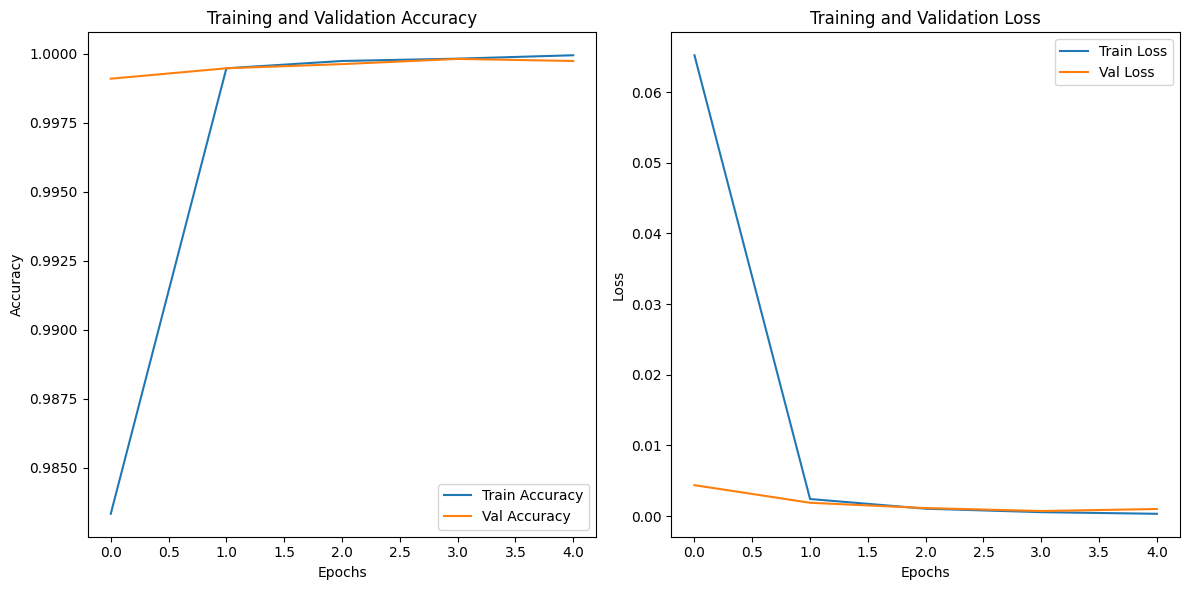

In [14]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Save the model
model.save('my_model.h5')
print("✅ Model trained and saved successfully!")

✅ Model trained and saved successfully!


In [16]:
# Display total confusion matrix entries
total_entries = conf_matrix.sum()
print(f"Total entries in the confusion matrix: {total_entries}")
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Total entries in the confusion matrix: 26492
828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9998 - loss: 5.4568e-04
Test Accuracy: 0.9998
Test Loss: 0.0007
